<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

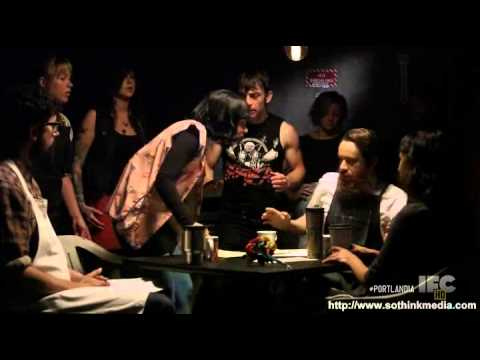

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'/Users/michael/Google Drive/lambda/4-1/DS-Unit-4-Sprint-1-NLP/module1-text-data'

In [63]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)

# Pulled out date value
shops['full_review_text'] = shops['full_review_text'].str.split(' ', 2)
shops['date'] = shops['full_review_text'].str[1]
shops['full_review_text'] = shops['full_review_text'].str[2]

# Cleaned 'star_rating'
shops['star_rating'] = shops['star_rating'].str[:2].astype(float)

shops.head()

,coffee_shop_name,full_review_text,star_rating,date
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! Eve...,5.0,11/25/2016
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Aust...",4.0,12/2/2016
2,The Factory - Cafe With a Soul,1 check-in Listed in Brunch Spots I loved the ...,4.0,11/30/2016
3,The Factory - Cafe With a Soul,Very cool decor! Good drinks Nice seating How...,2.0,11/25/2016
4,The Factory - Cafe With a Soul,1 check-in They are located within the Northcr...,4.0,12/3/2016


## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [96]:
import re
import spacy
from spacy.tokenizer import Tokenizer
from collections import Counter
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
def tokenize(df_column):
    '''
    Input: dataframe column of text
    Output: list of tokenized text
    '''
    tokenizer = Tokenizer(nlp.vocab)
    
    tokens = []
    
    for doc in tokenizer.pipe(df_column, batch_size=500):
        doc_tokens = []
        
        for token in doc:
            if (token.is_stop == False) & (token.is_punct == False):
                doc_tokens.append(token.text.lower())
                
        tokens.append(doc_tokens)
        
    return tokens

In [69]:
shops['tokens'] = tokenize(shops['full_review_text'])

In [85]:
nlp = spacy.load('en_core_web_lg')

In [89]:
STOP_WORDS = nlp.Defaults.stop_words.union(['coffee'])

In [90]:
def get_lemmas(text):
    '''
    Input: dataframe column of text
    Output: list of lemmas
    '''
    doc = nlp(text)
    
    lemmas = []
    
    for token in doc:
        if (token.text.lower() not in STOP_WORDS) & (token.is_punct == False) & (token.pos_ != 'PRON') & (token.is_alpha == True):
            lemmas.append(token.lemma_)
            
    return lemmas

In [91]:
shops['lemmas'] = shops['full_review_text'].apply(get_lemmas)

In [92]:
def count(docs):
        '''
        NEED TO ADD MY OWN FUNCTIONALITY HERE
        FEATURE: KEEP AVERAGE RATING
        '''
        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [93]:
good = shops[shops['star_rating'] >= 4]
bad = shops[shops['star_rating'] < 4]

In [94]:
bad_wc = count(bad['lemmas'])
good_wc = count(good['lemmas'])

In [97]:
def squarify_plot(df, threshold=20):
    top_n = df[df['rank'] <= threshold]
    squarify.plot(sizes=top_n['pct_total'], 
                  label=top_n['word'],
                  alpha=0.8)
    plt.axis('off')
    plt.show()

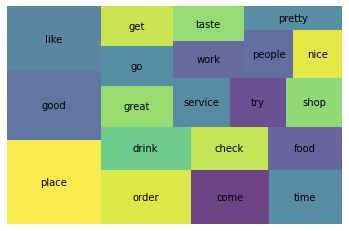

In [99]:
squarify_plot(bad_wc)

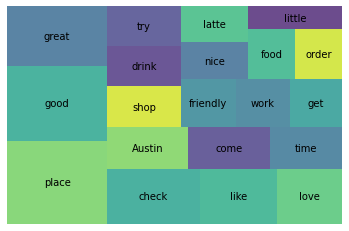

In [100]:
squarify_plot(good_wc)

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [ ]:
good_wc = good_wc.set_index('word')
bad_wc = bad_wc.set_index('word')

In [113]:
joined = good_wc.join(bad_wc, how='inner', lsuffix='_good', rsuffix='_bad')
joined.head()

,appears_in_good,count_good,rank_good,pct_total_good,cul_pct_total_good,appears_in_pct_good,appears_in_bad,count_bad,rank_bad,pct_total_bad,cul_pct_total_bad,appears_in_pct_bad
word,,,,,,,,,,,,
place,3123,4804,1.0,0.018096,0.018096,0.508632,752,1225,1.0,0.016561,0.016561,0.509485
good,2928,4344,2.0,0.016363,0.034459,0.476873,647,1000,2.0,0.013519,0.030080,0.438347
great,2497,3455,3.0,0.013014,0.047473,0.406678,347,462,10.0,0.006246,0.098513,0.235095
check,2686,2942,4.0,0.011082,0.058555,0.437459,488,526,8.0,0.007111,0.085535,0.330623
like,1677,2434,5.0,0.009168,0.067724,0.273127,596,945,3.0,0.012775,0.042855,0.403794


In [120]:
joined['diff'] = joined['appears_in_pct_good'] - joined['appears_in_pct_bad']
joined['diff_rank'] = joined['diff'].rank(method='first', ascending=False)
joined = joined.sort_values(by='diff_rank')

In [124]:
joined['diff'].head(10)

word
great        0.171583
delicious    0.124386
love         0.118303
friendly     0.107156
check        0.106836
Austin       0.087509
amazing      0.079747
perfect      0.074717
favorite     0.071473
in           0.064594
Name: diff, dtype: float64

In [125]:
joined['diff'].tail(10)

word
review     -0.077306
say        -0.078785
customer   -0.081228
taste      -0.084679
go         -0.087955
service    -0.092652
bad        -0.094466
ask        -0.098400
order      -0.125856
like       -0.130667
Name: diff, dtype: float64

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

